In [1]:
import pandas as pd
import geopandas as gpd
from datetime import time, timedelta, datetime, date 
import contextily as cx
import numpy as np
import json
import numpy as np
from pathlib  import Path
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point

In [2]:
#ho cambiato il percorso così da lavorare direttamente nella repo
data_path = Path('.././data/raw')
data_path2 = Path('.././data/external')
files = {'grid':'trentino-grid.geojson',
         'adm_reg':'administrative_regions_Trentino.json',        
         'NOV-DATA':'SET-nov-2013.csv',
         'DEC-DATA':'SET-dec-2013.csv',
         'SET-lines':'line.csv',
         'inquinamento' :  'APPA_inquinamento_aria_Nov_Dec_2013.csv',
         'meteo': 'meteotrentino-weather-station-data.json'
        }

In [3]:
# guardiamo dati riguardo l'inquinamento orario  nei mesi di dicembre e novembre 2013 
df_inquinamento= pd.read_csv(data_path2 / files['inquinamento'] , encoding='latin-1')
#pd.unique(df_inquinamento.Inquinante)

### Importiamo dati grid e li aggiustiamo

In [4]:
with open(data_path / files['grid']) as f:
    grid_json = json.load(f)

#comandi utili per capire cosa c'è nel file .json
#print(grid_json.keys())
#print(grid_json['crs'])
#print(grid_json['type'])
#grid_json['features'][1]
grid = gpd.GeoDataFrame(grid_json['features'])

#converto la colonna geometry nel formato Polygon di shapely
grid['geometry'] = grid['geometry'].apply(lambda x:Polygon(x['coordinates'][0]))

#### Questa parte imposta il crs del geoDataFrame ######
# Import specific function 'from_epsg' from fiona module
from fiona.crs import from_epsg
# Set the GeoDataFrame's coordinate system to WGS84
grid.crs = from_epsg(code = 4326)

/home/gianmarco/anaconda3/envs/DS_2022/lib/python3.8/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


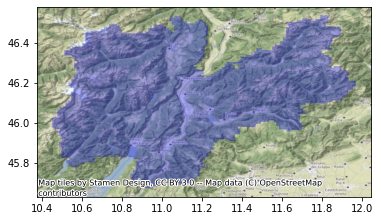

In [5]:
grid['id'] = grid['properties'].apply(lambda x: x['cellId'])
axgrid = grid.plot(color='blue', alpha=0.3) #vediamo che la mappa si plotta decentemente
#sovrappongo mappa del trentino
cx.add_basemap(axgrid, crs=grid.crs.to_string() ) 
#per salvare la figura :)
#plt.savefig("mappaTrentinoBlu.pdf", bbox_inches='tight' , dpi=300) 

### Prima analisi dei consumi elettrici lordi del mese

In [6]:
#creo dataframe con dati relativi ai consumi di ogni linea ogni 10 min
nomi = ['LINESET', 'time', 'consumi']
df_consumi = pd.read_csv(data_path / files['NOV-DATA'], names = nomi)
df_linee = pd.read_csv(data_path / files['SET-lines'])

In [7]:
#poiché la procedura dovrà essere ripetuta, meglio mettere tutto in una funzione 
def genera_mappa_consumi( datiConsumi, df_linee, grid ):
    ''' Restituisce GeoDataFrame per il plot di una mappa in scala di colore a partire dai dati relativi ai consumi.
        Inputs:
            
            datiConsumi:pd.DataFrame che contiene colonna con i codici di linea (LINESET) e i rispettivi consumi
            registrati in un certo giorno e orario.
            
            df_linee: pd.DataFrame che contiene: codici linea, celle per cui passa la linea,
            e nr. di utenze in quella cella.
            
            grid: gpd.GeoDataFrame che contiene le celle in cui è suddiviso il territorio come istanze della classe
                  Polygon (from shapely.geometry)
            
         Returns: 
         
            df_mappa: gpd.GeoDataFrame con il consumo totale su ogni cella del territorio trentino. 
         '''
    #contiamo le ubicazioni per linea
    df_ubi_per_line = pd.DataFrame(df_linee.groupby('LINESET')['NR_UBICAZIONI'].sum()).reset_index()
    #contiamo i consumi per linea
    df_con_per_line = pd.DataFrame( datiConsumi.groupby('LINESET')['consumi'].sum() ).reset_index()
    #uniamo i due dataframe
    df_consperub = pd.merge(left = df_con_per_line, right = df_ubi_per_line, how = 'outer',on='LINESET' )
    df_consperub = df_consperub.fillna(0)
    #calcolo dei consumi per ubicazione
    df_consperub['cons_per_ubi'] = df_consperub['consumi'] / df_consperub['NR_UBICAZIONI']
    #unisco al dataframe con le linee e le rispettive celle
    df_cons_per_cella = pd.merge(left = df_linee, right = df_consperub[['LINESET','cons_per_ubi']], how = 'outer',on='LINESET')
    df_cons_per_cella['consumo_per_cella'] = df_cons_per_cella['NR_UBICAZIONI']*df_cons_per_cella['cons_per_ubi']
    #sommo i consumi della stessa cella (diverse linee)
    df_cons_per_cella = pd.DataFrame(df_cons_per_cella.groupby('SQUAREID')['consumo_per_cella'].sum() ).reset_index()
    #finalmente unisco tutto al dataframe della mappa che viene ritornato
    df_mappa = pd.merge(left = grid, right = df_cons_per_cella, how = 'left', left_on='id', right_on='SQUAREID')
    df_mappa['consumo_per_cella'] = df_mappa['consumo_per_cella'].fillna(0)
    return df_mappa
    

In [8]:
#questa riga di codice serve per vedere se ci sono linee che passano in celle ma non hanno consumo, perchè evidentemente non hanno ubicazioni 
#spoiler nel dataset di novembre ce ne sono ben 37
#per ora abbandoniamo l'idea di un plot in scala logaritmica
#sum(df_mappa.consumo_per_cella == 0)

# tentativo di fare una scala logaritmica 
#df_mappa['log_consumi'] = np.log(df_mappa['consumo_per_cella'])
#mynorm = mpl.colors.LogNorm(vmin=np.nanmin(df_mappa.iloc[:,5].values) ,vmax=df_mappa['consumo_per_cella'].max() )
#df_mappa.plot('consumo_per_cella', cmap = 'YlOrRd', norm=mynorm)
#df_mappa['consumo_per_cella'].min()


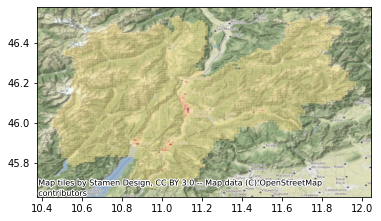

In [9]:
gdf_consumi_lordi = genera_mappa_consumi(df_consumi, df_linee, grid) 
ax_consumi_lordi = gdf_consumi_lordi.plot('consumo_per_cella', cmap='YlOrRd', alpha=0.5) 
cx.add_basemap(ax_consumi_lordi, crs=grid.crs.to_string() ) 

### Indagine sulle variazioni di consumi tra giorno e notte

In [10]:
# abbiamo diviso la colonna time in data e ora per riuscire a gestire meglio i dati
#df_consumi[['Date', 'hour']] =df_consumi['time'].str.split(' ', expand=True)
# divido le celle 
df_consumi[['giorno','ora']] = df_consumi.time.str.split(" ",expand=True)
df_consumi.time = df_consumi.time.apply(datetime.fromisoformat)
# uso magia di stack exchange per dividere il database in due database uno con i consumi diurni e uno con i consumi notturni 
mask = (pd.to_timedelta(df_consumi['ora'].astype(str).add(':00'))
          .between(pd.Timedelta('08:00:00'), pd.Timedelta('19:00:00')))
df_consumidiurni = df_consumi[mask]
df_consuminotturni = df_consumi[~mask]
#vogliamo arrivare alla loro differenza (normalizzata sul numero di ore!)

In [15]:
df_mappa_giorno = genera_mappa_consumi( df_consumidiurni, df_linee , grid)
df_mappa_notte = genera_mappa_consumi( df_consuminotturni, df_linee, grid)
#normalizzo i consumi per numero di ore nella giornata
df_mappa_giorno['consumo_per_cella']/=11
df_mappa_notte['consumo_per_cella']/=13
#df_mappa_giorno.head(40) #3762.252046
#df_mappa_notte#df_mappa_generale.head(40) #3762.25204
#df_mappa_generale = plotmap( df_consumi, df_linee, grid)

In [42]:
df_mappa_diff = df_mappa_giorno.copy()
df_mappa_diff['consumo_per_cella'] = -df_mappa_giorno['consumo_per_cella'] + df_mappa_notte['consumo_per_cella']

(46.0, 46.13)

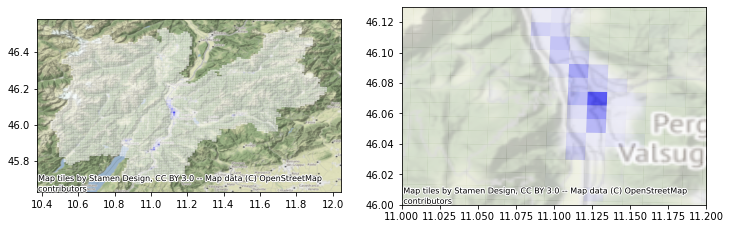

In [43]:
fig, axes = plt.subplots(1,2, figsize=(12,5) ) 
MAX = np.max(np.abs(df_mappa_diff['consumo_per_cella'] )  ) 
norm= plt.Normalize( -MAX, MAX ) 
#bwr: blue white red (in ordine crescente)
df_mappa_diff.plot('consumo_per_cella', cmap='bwr', alpha=0.5, ax=axes[0], norm=norm) 
df_mappa_diff.plot('consumo_per_cella', cmap='bwr', alpha=0.5, ax=axes[1], norm=norm) 
cx.add_basemap(axes[0], crs=grid.crs.to_string() )
cx.add_basemap(axes[1], crs=grid.crs.to_string() )
axes[1].set_xlim(11.0, 11.2) 
axes[1].set_ylim(46.0, 46.13)

In [ ]:
df_consumi

In [ ]:
# ho aggiunto una colonna che mi enumera i giorni della settimana 
df_consumi["giorno"] = pd.to_datetime(df_consumi["giorno"])
df_consumi["DayOfWeek"] = df_consumi["giorno"].dt.weekday
df_consumi

In [ ]:
# ho aggiunto un altra colonna che mi dice se il giorno è un week end o meno
df_consumi["isweekend"] = df_consumi["giorno"].dt.weekday > 4
Ntot = len(df_consumi.index)

In [ ]:
# adesso procedo a dividere in due il database in base alla condizione weekend o meno
# proverò a farlo con la stessa procesura seguita per il giorno e la notte 

In [ ]:
# sono riuscita a dividere i due database filtrando con la condizione sulla colonna DayOfweek molto più comoda di isweekend 

In [ ]:
df_consumisettimana = df_consumi[df_consumi.DayOfWeek < 5]
Nset = len(df_consumisettimana.index)


In [ ]:
df_consumiweekend = df_consumi[df_consumi.DayOfWeek > 4]

In [ ]:
df_mappa_settimana = plotmap( df_consumisettimana, df_linee , grid)
df_mappa_weekend = plotmap( df_consumiweekend, df_linee, grid)
#normalizzo
df_mappa_settimana['consumo_per_cella']/=Nset*144
df_mappa_weekend['consumo_per_cella']/=(Ntot-Nset)*144
# ci sono 144 righe ogni giorno 


In [ ]:
df_mappa_settimana

In [ ]:
#faccio la differenza tra i consumi della settimana e quelli del weekend.

df_mappa_weekend['DIFFCONSUMI'] = df_mappa_settimana['consumo_per_cella']-df_mappa_weekend['consumo_per_cella']


In [ ]:
df_mappa_weekend.plot('DIFFCONSUMI', cmap="YlOrRd")

In [ ]:
with open(data_path / files['adm_reg']) as f:
    adm_json = json.load(f)
print(adm_json.keys())

In [ ]:
from shapely.geometry import Point

In [ ]:
gdf_adm = gpd.GeoDataFrame(adm_json['items'])
gdf_adm['geometry'][0]['coordinates'][0][0][0]
punto = Point(  gdf_adm['geometry'][0]['coordinates'][0][0][0],gdf_adm['geometry'][0]['coordinates'][0][0][1]     ) 
#gdf_adm['geometry'] = gdf_adm['geometry'].dropna()
#gdf_adm = gdf_adm['geometry'].apply(lambda x:Point(  x['coordinates'][0][0][0],x['coordinates'][0][0][1]     ) )
#gdf_adm.explore()
#print(punto)

In [ ]:
gdf_adm.columns

In [ ]:
#gdf_comuni = gpd.GeoDataFrame( data=[gdf_adm['name'], gdf_adm['geometry']  ], index=gdf_adm.index ) 
gdf_comuni = gdf_adm[['name','geometry']]
gdf_comuni
dgrouped = gdf_comuni.groupby('name')['geometry'].sum()
gdf_com = pd.DataFrame(dgrouped)
gdf_com = gdf_com.reset_index()
gdf_com = gdf_com[gdf_com.geometry != 0]
print(gdf_com)

In [ ]:
gdf_com['geometry'][11]

In [ ]:
#df_adm['geometry'] = df_adm['geometry'].apply(lambda x:Polygon(x['coordinates']))
#df_adm.head(165)

In [ ]:
# uso magia di stack exchange per dividere il database in due database uno con i consumi diurni e uno con i consumi notturni 
maskday = (pd.to_timedelta(df_consumi['ora'].astype(str).add(':00'))
          .between(pd.Timedelta('08:00:00'), pd.Timedelta('19:00:00')))
maskevening = (pd.to_timedelta(df_consumi['ora'].astype(str).add(':00'))
          .between(pd.Timedelta('19:00:00'), pd.Timedelta('24:00:00')))

In [ ]:
df_consumiday = df_consumi[maskday]
df_consumievening = df_consumi[maskevening]
df_consumiday = df_consumiday[df_consumiday.DayOfWeek < 5]
df_consumiday
df_consumievening = df_consumievening[df_consumievening.DayOfWeek < 5]
df_consumievening

In [ ]:
# possiamo dividere i dati fra train e test 

In [ ]:
def calcolaconsumi( datiConsumi, df_linee, grid ):
    ''' Plotta una mappa in scala di colore a partire dai dati relativi ai consumi (descrizione da completare)'''
    dgrouped1 = df_linee.groupby('LINESET')['NR_UBICAZIONI'].sum()
    df_ubi = pd.DataFrame(dgrouped1)
    ##print(df_ubi)
    dgrouped = datiConsumi.groupby(['LINESET', 'giorno'])['consumi'].sum()
    df_con1 = pd.DataFrame(dgrouped)
    df_con1 = df_con1.reset_index()
    ##print(df_con1)
    #df_con1['giorno'] = df_con1['giorno'].apply(date.fromisoformat)
    df_consperub = pd.merge(left = df_con1, right = df_ubi, how = 'outer',on='LINESET', left_on=None, right_on=None,left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None  )
    #print(df_consperub.isna().sum()) avevo provato a contare i nan 
    # non curiamo i nan perchè causano problemi nel groupby
    df_consperub['cons_per_ubi'] = df_consperub['consumi'] / df_consperub['NR_UBICAZIONI']
    ##print(df_consperub)
    df_cons_per_cella = pd.merge(left = df_linee, right = df_consperub[['LINESET','giorno','cons_per_ubi']], how = 'outer',on='LINESET', left_on=None, right_on=None,left_index=False, right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None  )
    df_cons_per_cella['consumo_per_cella'] = df_cons_per_cella['NR_UBICAZIONI']*df_cons_per_cella['cons_per_ubi']
    ##print(df_cons_per_cella.dtypes)
    #df_cons_per_cella[['solo_giorno','ora']] = df_cons_per_cella.giorno.str.split(" ",expand=True)
    #df_cons_per_cella['giorno'] = df_cons_per_cella['giorno'].apply(str())
    ##print(df_cons_per_cella)
    dgrouped2 = df_cons_per_cella.groupby(['SQUAREID', 'giorno'])['consumo_per_cella'].sum()
    df_cons_per_cella = pd.DataFrame(dgrouped2)
    df_cons_per_cella = df_cons_per_cella.reset_index()
    ##print(df_cons_per_cella)
    #df_mappa_ = pd.merge(left = grid, right = df_cons_per_cella, how = 'left', left_on='id', right_on='SQUAREID'  )
    #df_mappa_['consumo_per_cella'] = df_mappa_['consumo_per_cella'].fillna(0)
    return df_cons_per_cella
    

In [ ]:
df_datidaclassificaregiorno = calcolaconsumi(df_consumiday , df_linee, grid )
df_datidaclassificaregiorno
df_datidaclassificaresera = calcolaconsumi(df_consumievening, df_linee, grid )
df_datidaclassificaresera